# Numerical Optimization
## Assignement 1 
### Leon Kalderon

Role of Pivoting

The role of pivoting is to reduce instability(e.g Zero Pivots or Relatively Small Pivots) that is inherent in Gaussian elimination. Instability
arises only if the factor L or U is relatively large in size compared to A. Pivoting reduces instablilty
by ensuring that L and U are not too big relative to A. By keeping all of the intermediate quantites
that appear in the elimination process a managable size, we can minimize rounding errors. 

source: http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-reid-LU-pivoting.pdf

General:
<br>
In order to have consistency in our code we tried to implement all the operations with numpy package.
However, in some cases, numpy is not as efficient as the build-in python's operations. For example, when we add a mask to a table (np.add(U, MASK) ) numpy tries to allocate new space in memory to do the addition. Python can avoid that with '+='.
In general, apart from the case mentioned above, we do all the operations with numpy. We could improve our performance ~20% if we replace similar operations but we prefered to show the numpy library because it is widely used in data science practices.
<br>

The code below have been implemented from scratch

In [1]:
import numpy as np
import time
def LU(A, pivoting = 'Partial'):
    
    #pivoting parameter defines the pivot method (Partial or Complete)
    if pivoting == 'Partial':
        #Set the dimension of the array
        n = len(A)

        #Initialize arrays
        #Instead of copying the matrix A to a new matrix U we could use A as U in order to save memory.
        U = np.matrix(A) #Upper triangunal matrix
        L = np.identity(n) #Lower triangunal matrix with ones in diagonal
        P_index = np.arange(n) #Array with the indecies of permutations
        
        #We create this array in order to store the Lj's (-Uij/pivot). We initialize it here in order to avoid allocating 
        #memory in each iteration
        c = np.zeros(n)       
        

        #Loop through columns of A
        for k in range(0, n):

            #Find the index of the row with the maximum value (at the current column). ~n^2 floops in total 
            maxRow = np.argmax(abs(U[k:,k])) + k
            
            #if the max value is not in the first row of the current sub-column swap rows   
            if k != maxRow:
                P_index[k], P_index[maxRow] = P_index[maxRow], P_index[k]
                U[k,:], U[maxRow,:] = U[maxRow,:].copy() ,U[k,:].copy()
                L[k, :], L[maxRow, :] = L[maxRow, :], L[k, :].copy()        

                    
            #Apply Gaussian elimination   ~2/3*n^3 floops in total
            #In order to avoid subtracting multiples of rows with a loop 
            #we tried to transorm the gaussian elimination to a matrix addition            
            c = np.zeros(n) 
            c[k + 1:] = np.divide(np.multiply([-1],U[k + 1:, k]), U[k, k]).flatten()            
            #We know from the theory the matricies L1,L2,...,Ln can be compacted to the matrix L just by stacking the columns            
            L[:,k] = c   
            #We add the 'mask' matrix to the matrix U      
            U[k:,k:] += np.outer(c[k:], U[k, k:])
        
        #We transform the P_index to a pertubed identity matrix so when we multiply P*A we have the pertubed A    
        P = np.zeros((n, n))
        for i in range(0, n):
            P[i, P_index[i]] = 1

        #From the theory we know that the inverse of the matrix L is the matrix L with the oposite 
        #sign to the values under the diagonal
        L = np.multiply(np.tril(L, k=-1),[-1]) + np.identity(n)        
        return P, L, U
    
    elif pivoting == 'Complete':
        
        #The implementation of the Complete pivoting is similar to Partial with only one major difference.
        #Instead of searching in each iteration the maxValue of the column we search for the max values in the whole submatrix.
        #and we tranfer it to the pivot position. Because of that we have to swap both rows and columns in each iteration.
        n = len(A)   
        U = np.matrix(A)
        L = np.identity(n)
        P_index = np.arange(n) 
        Q_index = np.arange(n)
        c = np.zeros(n)

      
        for k in range(0, n):            
            
           
            #~O(n^3). This part is the main reason of the execution time difference between Complete and Partial
            maxElem = np.argmax(abs(U[k:, k:]))
            maxRow, maxCol = np.divmod(maxElem, n-k)
            maxRow += k
            maxCol += k           
            
            if k != maxRow:
                P_index[k], P_index[maxRow] = P_index[maxRow], P_index[k]
                U[k,:], U[maxRow, :] = U[maxRow, :].copy() ,U[k,:].copy()
                L[k, :], L[maxRow, :] = L[maxRow, :], L[k, :].copy()

            if k != maxCol:
                Q_index[k], Q_index[maxCol] = Q_index[maxCol], Q_index[k]     
                U[:,k], U[:, maxCol] = U[:,maxCol].copy() ,U[:,k].copy()

            c = np.zeros(n)        
            c[k + 1:] = np.divide(np.multiply([-1],U[k + 1:n, k]), U[k, k]).flatten()
            L[:,k] = c            
            U[k:,k:] += np.outer(c[k:], U[k, k:]) 

        P = np.zeros((n, n))
        for i in range(0, n):
            P[i, P_index[i]] = 1

        Q = np.zeros((n,n))
        for i in range(0,n):
            Q[Q_index[i],i] = 1

        L = np.multiply(np.tril(L, k=-1),[-1]) + np.identity(n)
        
        return P, L, U, Q 

In [2]:
#Here we define the function that solves the system when we have a decomposed matrix to PLU or PLUQ form.
def solve_LU( L, U, b, P = None, Q = None):
    
    #We tried to implement the backward and forward substituion with vector operations. Because of that we avoided one
    #loop in each case and the exec.time difference was huge.
    
    n = len(L)    
    #Permute b
    if(P is not None):
        b = np.matmul(P,b).transpose()
        
    # Perform Ly=b by forward substitution ~n^2 flops
    y = np.zeros(n)    
    for i in range(0,n):
        y[i] = np.subtract(b[i], np.dot(L[i,:i], y[:i]))
                    
    # Perform Ux=y by back substitution ~n^2 flops
    x = np.zeros(n)
    for i in range(n-1,-1,-1):           
        x[i] = np.divide(np.subtract(y[i], np.dot(U[i,i+1:], x[i+1:])), U[i,i])   
                                  
    #complete pivoting
    if(Q is not None):
        x = np.matmul(Q, x.T)
        
    #total flops ~2n^2
    return x

### LU decomposition and forward/backward substitution for 10 random matricies(2048x2048)
~7 minutes execution time

In [3]:
#We execute for 10 random matricies(2048x2048)the LU decomposition with partial and complete pivoting to count the mean execution time
#and then we solve the systems with each method to calculate the mean error and correction over the infinity norm.
#~7min to execut
TimePartial = []
ErrorPartial = []
CorrectionPartial = []

TimeComplete = []
ErrorComplete = []
CorrectionComplete = []

LU_Matricies = []

for i in range(0,10):
    A = np.random.rand(2048, 2048)*10
    x_true = np.random.rand(2048)*10
    b = np.matmul(A, x_true)

    start = time.time()
    P,L,U = LU(A)
    end = time.time()
    TimePartial.append(end-start)
    LU_Matricies.append([P,L,U])
   
    x = solve_LU(L,U, b, P = P)
    ErrorPartial.append(np.linalg.norm(abs(x_true-x), np.inf))
    CorrectionPartial.append(np.linalg.norm(abs(np.matmul(A,x)-b), np.inf))
    
    start = time.time()
    P,L,U,Q = LU(A, pivoting = 'Complete')
    end = time.time()
    TimeComplete.append(end-start)
    
    x = solve_LU(L,U, b, P = P, Q=Q)
    ErrorComplete.append(np.linalg.norm(abs(x_true-x), np.inf))
    CorrectionComplete.append(np.linalg.norm(abs(np.matmul(A,x)-b), np.inf))    

In [7]:
#Partial Pivoting Scores
mean_TimeP = np.mean(TimePartial)
mean_ErrorP = np.mean(ErrorPartial)
mean_CorrectionP = np.mean(CorrectionPartial)

#Complete Pivoting Scores
mean_TimeC = np.mean(TimeComplete)
mean_ErrorC = np.mean(ErrorComplete)
mean_CorrectionC = np.mean(CorrectionComplete)

print('PARTIAL PIVOTING')
print('Average exeuction time: ', mean_TimeP)
print('Average error: ', mean_ErrorP)
print('Average correction: ', mean_CorrectionP)
print()
print('COMPLETE PIVOTING')
print('Average exeuction time: ', mean_TimeC)
print('Average error: ', mean_ErrorC)
print('Average correction: ', mean_CorrectionC)

PARTIAL PIVOTING
Average exeuction time:  21.513371109962463
Average error:  1.5585635004811138e-10
Average correction:  1.6079866327345372e-10

COMPLETE PIVOTING
Average exeuction time:  40.4237952709198
Average error:  1.5692915855680666e-10
Average correction:  1.0622898116707802e-10


PC specifications: processor HQ6700 and 16GB RAM
Results:

PARTIAL PIVOTING
<br>
Average exeuction time: 20.472789669036864
<br>
Average error: 1.0055005716935739e-10
<br>
Average correction:  1.520675141364336e-10

COMPLETE PIVOTING
Average exeuction time:  38.21425297260284
<br>
Average error:  6.797509222167263e-11
<br>
Average correction:  9.749783203005791e-11

From the above results, we observe  that both methods achieve a quite accurate solution of the systems. More specifically, partial pivoting is ~10 digits accurate vs complete that is ~11 digits accurate(when we calculate the error and correction over the infinity norm). However, partial pivoting has ~20 seconds execution time vs the complete that has ~38. 
<br>
As a result, we could claim that it is more efficient to use partial pivoting because it has almost the same error as the complete but a quite big difference in execution time.

The difference of the execution times (between partial and complete pivoting GE) is quite consistent to the theory (small discrepancies may occur due to the code procedure).
<br>
Gaussian Elimination ~$2/3*n^2$
<br>
Partial Pivoting ~ $n^2$
<br>
Complete Pivoting ~$n^3$
<br>
Forward/Backward Substitution ~$n^2$ (total floops to solve the system of a decomposed matrix $2n^2$)
<br>
Thus, GE with partial pivoting needs ~$2/3*n^3 + n^2$ (~20 sec mean exec. time in our example)
<br>
GE with complete pivoting needs ~$2/3*n^3 + n^3$ (~40 sec mean exec.time in our example)

In [8]:
#Construct the special case matrix
SP = np.identity(2048)
il1 = np.tril_indices(2048, k=-1)
SP[il1] = -1
SP[:, 2048-1] = 1

### Execute Gaussian Elimination with Partial Pivoting on the special matrix

In [12]:
start = time.time()
P,L,U = LU(SP, pivoting = 'Partial')
x_true = np.random.rand(2048)*10
b = np.matmul(SP, x_true)

x2 = solve_LU(L,U, b, P = P)
end = time.time()

print('GE with Complete pivoting:')
print('Exec.time', end-start)
print('Error',np.linalg.norm(abs(x_true-x2), np.inf))
print('Correction', np.linalg.norm(abs(np.matmul(SP,x2)-b), np.inf))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in add
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:1120: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)


GE with Complete pivoting:
Exec.time 19.131837844848633
Error nan
Correction nan


Observations:

<br>
With partial pivoting in each iteration we swap the largest absolute value of the current column to the pivot position.
Because all the values of each column are the same in each iteration the algorithm does not swap any row and the scalars/multipliers(-Uij/Upivot) that we multiply each row in order to nullify the values below the pivot, are 1.
<br>
As a result, since the elements of the last column have the opposite signs than the pivots, the eliminations will double the value of the next row in each iteration. 
<br>
Last column's pattern: $[2^0, 2^1, 2^2, ...., 2^{2048}]^T$.
<br>
As we just mentioned, the values in the last column become huge when n increases. That is a very important problem because, not only we will probably have problem with numerical instabilities when we do operations with these numbers(e.g. when we do forward and backward elimination to solve the system) but also these numbers cannot be represented by the computer on Double-precision floating-point format!
<br>
In this DPP format the biggest number that we can represent is ~$2^{1023}$ (~$10^{307}$). As a result the values in indecies >1023 will be NaNs because we cannot represent such numbers in our computers!  

### Execute Gaussian Elimination with Complete Pivoting on the special matrix

In [14]:
start = time.time()
P,L,U, Q = LU(SP, pivoting = 'Complete')
x_true = np.random.rand(2048)*10
b = np.matmul(SP, x_true)

x = solve_LU(L,U, b, P = P, Q=Q)
end = time.time()

print('GE with Complete pivoting:')
print('Exec.time', end-start)
print('Error',np.linalg.norm(abs(x_true-x), np.inf))
print('Correction', np.linalg.norm(abs(np.matmul(SP,x)-b), np.inf))

GE with Complete pivoting:
Exec.time 35.18087935447693
Error 1.5969447986208252e-12
Correction 1.8189894035458565e-12


It is quite straightforward why Complete Pivoting solves the problem we discussed above.
<br>
Because Complete pivoting swaps the max absulute value's column and row to the pivot position, in the second iteration where the last column will have the values 2 (except the first element which it will be 1), the column will be transfered to the pivot position and all the elements below the pivot (that in our cases is the 'ill' column will become zero).  

The form of the matrix on the 2nd iteration after the swaps:
<br>
2nd iteration:
<br>
$11  0 .......0$
<br>
$020 .......1$
<br>
$..22 1...-1$
<br>
$... -1 ..-1$
<br>
$... .....-1$
<br>
$02..-1 ...-1$
<br>
 

### Sherman-Morrison formula

When we have the LU decomposition of a matrix and we want to solve the system for a corrected A by a rank 1 matrix instead of recalculating the LU decomposition of $\tilde{A}$ we can use the Sherman-Morrison formula and save a lot of time.

$Formula$

$\tilde{A}^{-1} = (A + uv^T)^{-1} = A^{-1} - \frac{A^{-1}uv^TA^{-1}}{1 + v^TA^{-1}u}$   proof:https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula

Thus, when we want to solve $\tilde{A}y=d$ we can solve:
<br>
$y = (A + uv^T)^{-1}d = (A^{-1} - \frac{1}{1 + v^TA^{-1}u}A^{-1}uv^TA^{-1})d$   

As a result from the above equation, in order to find y, we just need to solve with forward/backward elimination:
<br>
$A^{-1}d = z <=> LUd = z$    ->  ~2n^2 floops
<br>
$v^Tz$ -> n floops
<br>
$A^{-1}u = k <=> LUu = k $ -> ~2n^2 floops

In general, we can solve a linear system with $O(n^2)$ with Sherman-Morrison Formula

In [5]:
#Generate random vectors u,v
u = np.random.rand(2048,1)*30
u=u/np.linalg.norm(u)

v = np.random.rand(2048,1)*30
v = v/np.linalg.norm(v)

In [6]:
def sherman_morrison(P,L,U,b,u,v):
    z = solve_LU(L, U, b, P = P)
    k = solve_LU(L, U, u.flatten(), P = P)
    
    x_sm = z - ((1/(1+np.matmul(v.transpose(),k)))* k )* np.matmul(v.transpose(),z)
    return x_sm

start = time.time()
sherman_morrison(LU_Matricies[0][0], LU_Matricies[0][1], LU_Matricies[0][2], b,u,v)
end = time.time()
total = end-start
total

0.13948631286621094

In the list LU_matricies we had store all the LU decompositions of the 10 random matricies generated in the first part of the excercise.
<br>
We solve the the linear systems for all the 10 corrected matricies by a ranked 1 matrix and we calculate the mean execution time. 

In [11]:
sm_exectm = []
for i in range(0,10):
    start = time.time()
    sherman_morrison(LU_Matricies[i][0], LU_Matricies[i][1], LU_Matricies[i][2], b,u,v)
    end = time.time()
    total = end-start
    sm_exectm.append(total)

mean_sm = np.mean(sm_exectm)    
print('Mean exec.time with Sherman-Morrison:', mean_sm)

Mean exec.time with Sherman-Morrison: 0.09723839759826661


Results:
<br>
Mean execution time with SM formula ~0.1.
<br>

In order to show the difference in computational complexity of the two methods we solve for matricies with different sizes and then we check how the execution time changes as the n increases.

The following code has execution time ~20mins.
<br>
In order to save time, we run the script and in the next cell we stored the results thus there is no need to re-run it again .

In [25]:
# x_axis = []
# y_sm = []
# y_lu = []
# for i in range(100,5000,500):
#     A = np.random.rand(i, i)*10
#     x_true = np.random.rand(i)*10
#     b = np.matmul(A, x_true)
    
#     u = np.random.rand(i,1)*30
#     u=u/np.linalg.norm(u)

#     v = np.random.rand(i,1)*30
#     v = v/np.linalg.norm(v)
    
#     P,L,U = LU(A)
#     #sherman-morrison solve given that already have LU of A
#     start = time.time()
#     sherman_morrison(P, L, U, b,u,v)
#     end = time.time()
#     x_axis.append(i)
#     y_sm.append(end-start)
    
#     #Solve the corrected A by recalculating LU decomposition and then solve the system
#     start = time.time()
#     correction = np.outer(u,v)
#     A += correction
#     start = time.time()
#     P,L,U = LU(A)
#     x = solve_LU(L,U, b, P = P)
#     end = time.time()
#     y_lu.append(end-start)    

In [1]:
n = [100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600]
execTime_lu = [0.01595, 0.46974, 3.13864, 8.67679, 19.58362, 36.51834, 62.13283, 96.72433, 153.56743, 235.17306]
execTime_sm = [0.00897, 0.0309169, 0.051861, 0.07081, 0.11070, 0.15658, 0.15761, 0.19647, 0.21542, 0.24733]

It is obvious that as n increases the execution time with LU increases in a much sharper rate than that of the SM formula.
<br>
The difference of complexity is obvious just by looking the numbers.
<br>
However, we will try to plot the points of two approaches in order to show that the two curves have differt degree.

<function matplotlib.pyplot.show(*args, **kw)>

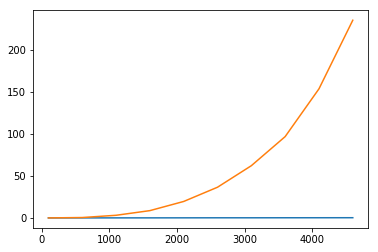

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n, execTime_sm)
plt.plot(n, execTime_lu)
plt.show

Plotting the two curves of execution times side by side it is obvious that lu method has a bigger degree of complexity.
However, for that small n we cannot show that the curve of SM is $O(n^2)$.